# Compare polynomial fitting with neural network regressor

## In this example, a noisy cosine function is fitted by 3 polynomes of different orders, and 3 neural networks with different layers sizes.

***

### Import usefull libraries.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The polynomial fit is performed using the scikit modules. 

In [2]:
# Import stuff to perform the polynomial fit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Import tool to compute rms
from sklearn.metrics import mean_squared_error
# Import the TMNI. If not installed, install it
try:
    import tmniai as tm
except:
    !pip install -U git+https://github.com/taller-mexicano-de-nebulosas-ionizadas/AI.git
    import tmniai as tm

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Define the function we want to interpolate.

In [7]:
def true_fun(x):
    return np.cos(1.5 * np.pi * x)

### Define some parameters. The X_train and y_train sets are used to determine the polynome coefficients and also to train the neural networks. 

In [8]:
# A random seed to reproduce the results
np.random.seed(0)

# The number of points used to fit the function
n_samples = 30

# Noise to be added to the points used to fit the function
noise = 0.1

# The training set: n_samples X points, with the noisy correspoing y  
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * noise
X_train = X
y_train_true = y

# The set of points to verify the fit quality
X_test = np.linspace(0, 1, 100)
y_test_true = true_fun(X_test)

### The pipeline object is defined to fit the X_train - y_train data sets. The order of the polynome is set to 2.

In [23]:
degree = 2
polynomial_features = PolynomialFeatures(degree=degree,
                                         include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train[:, np.newaxis], y_train_true);

### The RMS of the fit computed on the dataused to determine the coefficients is computed.

In [24]:
y_train = pipeline.predict(X_train[:, np.newaxis])
rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))

### The RMS of the fit computed on the test sample (100 points between 0 and 1) is computed.

In [25]:
y_test = pipeline.predict(X_test[:, np.newaxis])
rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

### A plot is done to show the original function, the training sample and the polynomial fit.

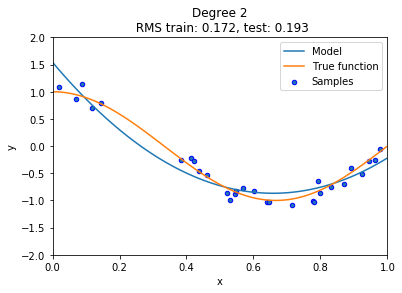

In [26]:
f, ax = plt.subplots()
ax.plot(X_test, y_test, label="Model")
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("Degree {}\n RMS train: {:.3f}, test: {:.3f}".format(degree,
             rms_train, rms_test));

### A Neural Network is used on the same data points. 

### It is trained on the training sets. Hyper-parameters can be changed.

In [50]:
RM = tm.manage_RM(RM_type='ANN', X_train=X_train, y_train=y_train_true, scaling=True,
                  verbose=False, random_seed=10)
RM.init_RM(hidden_layer_sizes=(4), 
           tol=1e-6, max_iter=1000, 
           activation='tanh',
           solver='adam')
RM.train_RM()

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Predictions of the ANN are performed on the training and test sets.

In [54]:
RM.set_test(X_train, scaleit=True)
RM.predict(scoring=False)
y_train = RM.pred
rms_train = np.sqrt(mean_squared_error(y_train, y_train_true))
RM.set_test(X_test, scaleit=True)
RM.predict(scoring=False)
y_test = RM.pred
rms_test = np.sqrt(mean_squared_error(y_test, y_test_true))

### A plot is done to show the original function, the training sample and the polynomial fit.

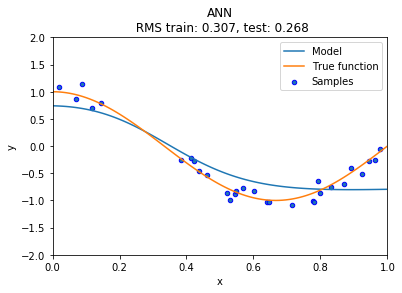

In [52]:
f, ax = plt.subplots()
ax.plot(X_test, y_test, label="Model")
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("ANN\n RMS train: {:.3f}, test: {:.3f}".format(
             rms_train, rms_test));

### A comparison is made between 3 polynomial fits and 3 ANN computations.

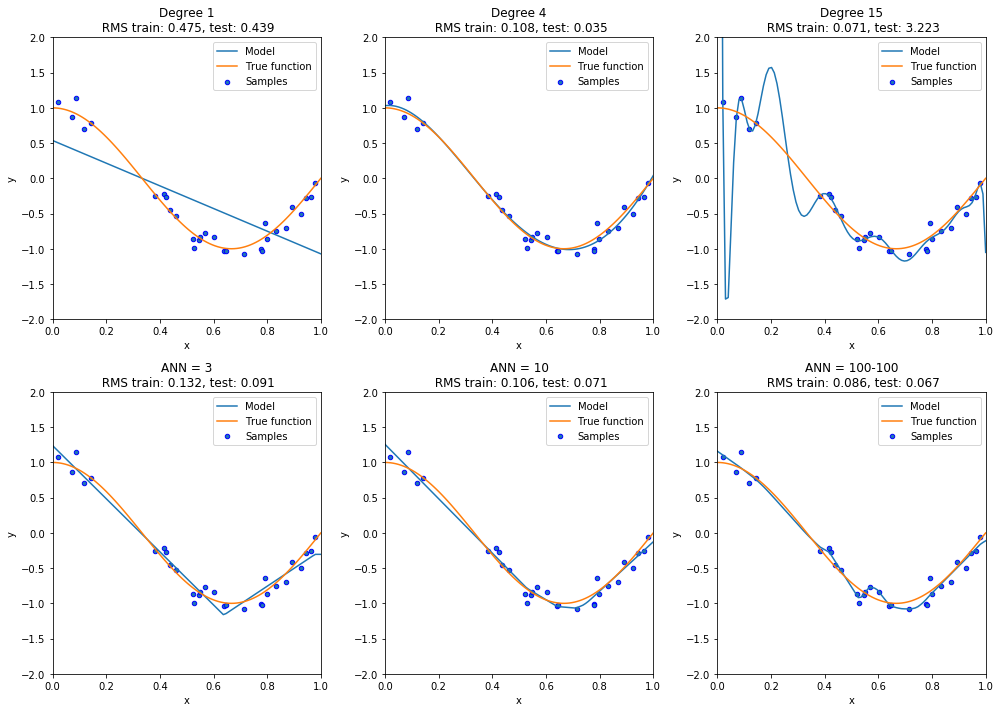

In [55]:
f, axes = plt.subplots(2, 3, figsize=(14, 10))

degrees = [1, 4, 15]
for i in range(len(degrees)):
    ax = axes[0,i]

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[:, np.newaxis], y_train_true)
    y_train = pipeline.predict(X_train[:, np.newaxis])
    y_test = pipeline.predict(X_test[:, np.newaxis])
    rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))
    ax.plot(X_test, y_test, label="Model")
    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Degree {}\n RMS train: {:.3f}, test: {:.3f}".format( degrees[i],
                 rms_train, rms_test))

hidden_layer_sizes_set = ( (3,), (10), (100, 100))
hidden_layer_sizes_strs = ('3', '10', '100-100')
for i in range(len(hidden_layer_sizes_set)):
    scaleit=True
    RM = tm.manage_RM(RM_type='ANN', X_train=X_train, y_train=y_train_true, scaling=scaleit,
                      verbose=False, random_seed=10)
    RM.init_RM(hidden_layer_sizes=hidden_layer_sizes_set[i], 
               tol=1e-6, max_iter=10000, 
               activation='relu',
               solver='adam')
    RM.train_RM()
    RM.set_test(X_train, scaleit=scaleit)
    RM.predict(scoring=False)
    y_train = RM.pred
    RM.set_test(X_test, scaleit=scaleit)
    RM.predict(scoring=False)
    y_test = RM.pred
    rms_train = np.sqrt(mean_squared_error(y_train, y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test, y_test_true))
    ax = axes[1,i]
    ax.plot(X_test, y_test, label="Model")
    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("ANN = {}\n RMS train: {:.3f}, test: {:.3f}".format(hidden_layer_sizes_strs[i],
                 rms_train, rms_test))
f.tight_layout()